<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_8_Generation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    with_info=True,
    split='train'
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

## Визуализация датасета LFW

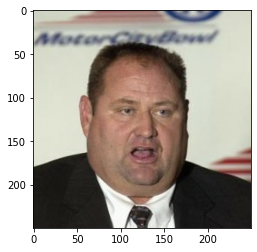

In [5]:
for example in train_ds.take(1):  # Only take a single example
    image = example['image']
    plt.imshow(image.numpy().astype(np.float32)/255)

In [0]:
train_x = [tf.image.rgb_to_grayscale(x['image'].numpy().reshape(250, 250, 3)) for x in train_ds]

In [7]:
train_x[0].shape

TensorShape([250, 250, 1])

In [8]:
len(train_x)

13233

## Deep Convolutional GAN (DCGAN)

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

##Подготовка датасета

In [0]:
def prepare(img):
  img = tf.cast(img, tf.float32) / 255.
  return tf.image.resize(img, (28, 28))

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 20
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=len(train_x))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [12]:
train_ds

<BatchDataset shapes: (16, 28, 28, 1), types: tf.float32>

In [0]:
def plot_pics(samples):
    fig = plt.figure(figsize=(20, 20))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()

[Step  0] D Loss: 0.7449; G Loss: 0.6775


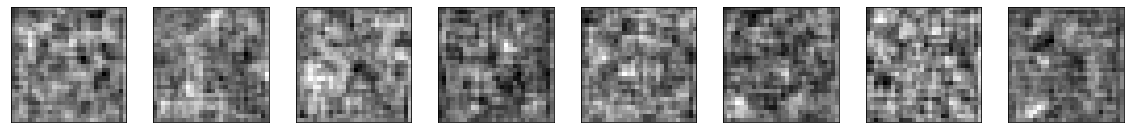

[Step 200] D Loss: 0.0182; G Loss: 0.1154


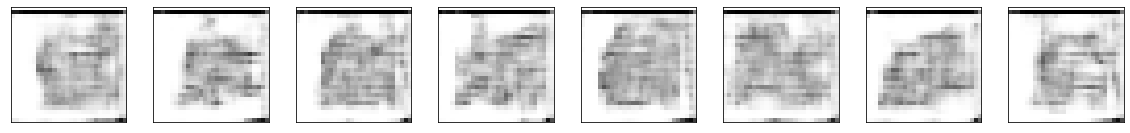

[Step 400] D Loss: 0.5261; G Loss: 4.1774


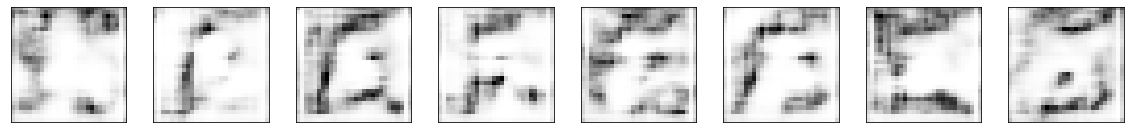

[Step 600] D Loss: 0.2982; G Loss: 0.9172


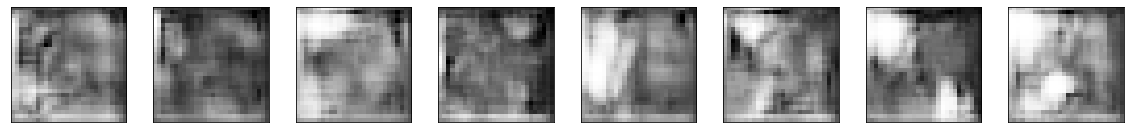

[Step 800] D Loss: 0.2550; G Loss: 3.8869


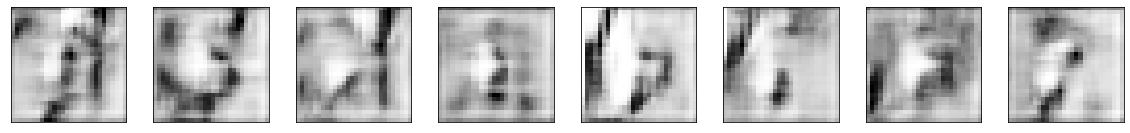

[Step 1000] D Loss: 0.4234; G Loss: 1.8474


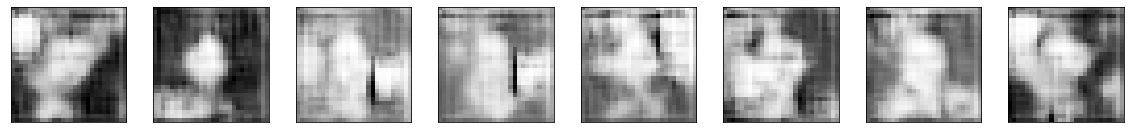

[Step 1200] D Loss: 0.4287; G Loss: 0.8071


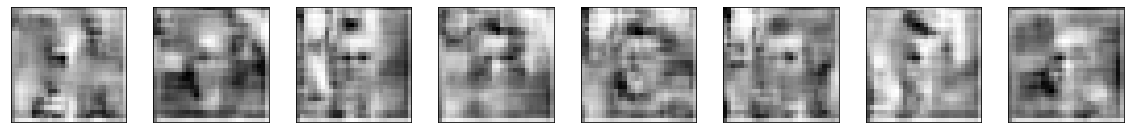

[Step 1400] D Loss: 1.0024; G Loss: 1.0706


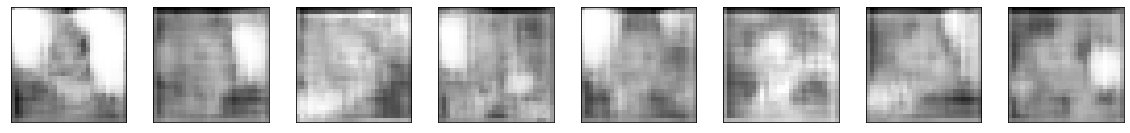

[Step 1600] D Loss: 0.3919; G Loss: 2.1715


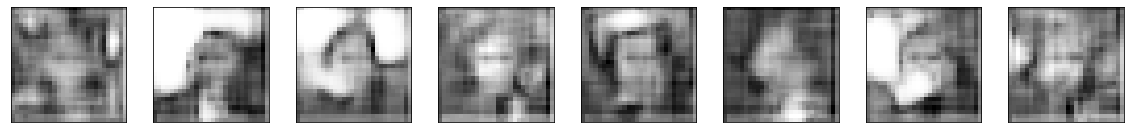

[Step 1800] D Loss: 0.4941; G Loss: 1.8295


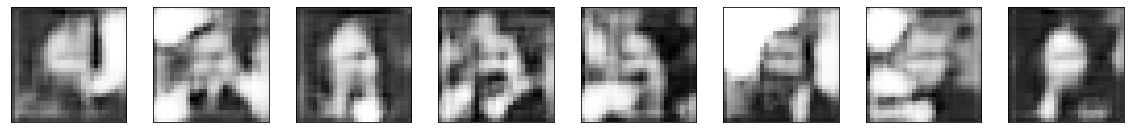

[Step 2000] D Loss: 0.6766; G Loss: 0.9836


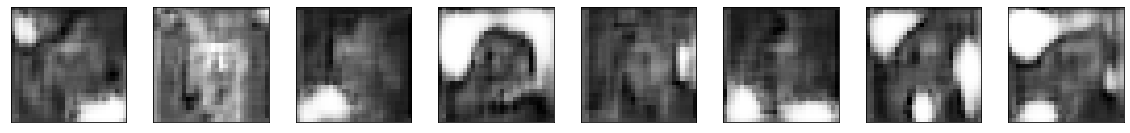

[Step 2200] D Loss: 0.4244; G Loss: 1.4274


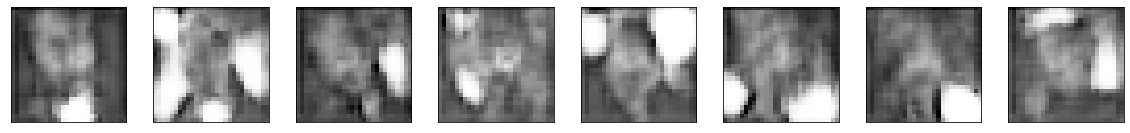

[Step 2400] D Loss: 0.5692; G Loss: 0.8591


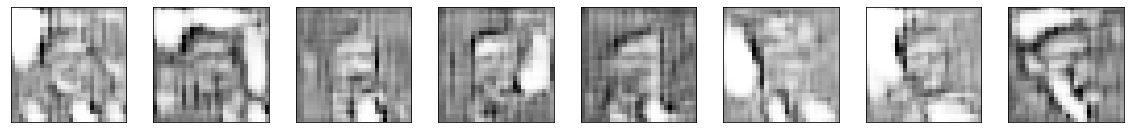

[Step 2600] D Loss: 0.6377; G Loss: 0.9828


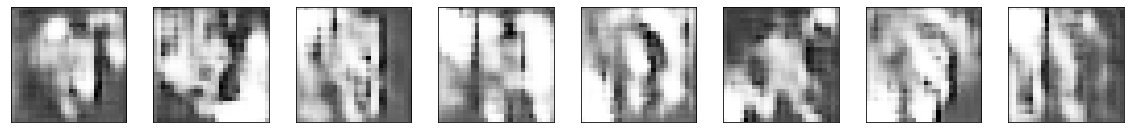

[Step 2800] D Loss: 0.3751; G Loss: 0.6221


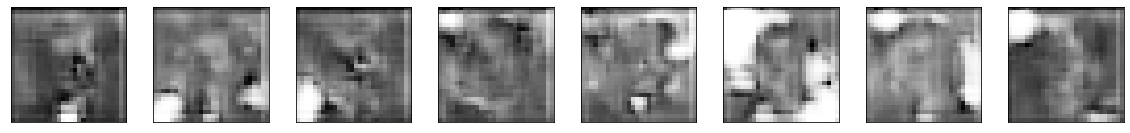

[Step 3000] D Loss: 0.6821; G Loss: 1.4096


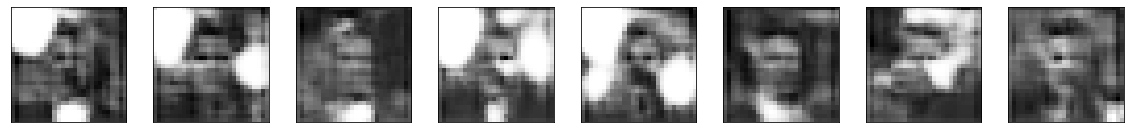

[Step 3200] D Loss: 0.6047; G Loss: 1.8635


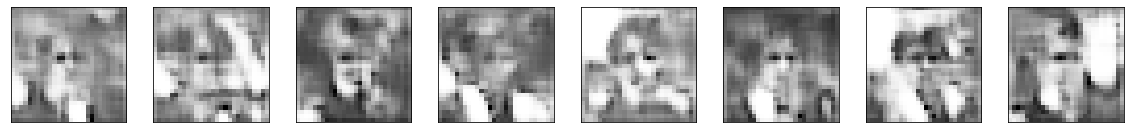

[Step 3400] D Loss: 0.4510; G Loss: 1.4099


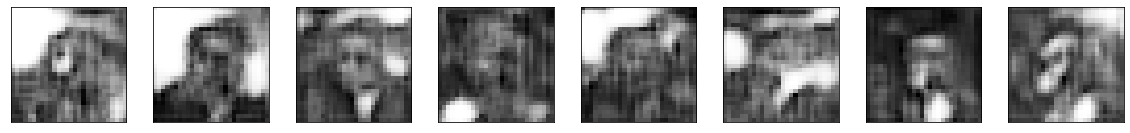

[Step 3600] D Loss: 0.4313; G Loss: 1.3392


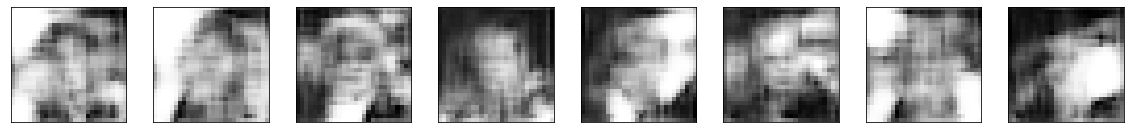

[Step 3800] D Loss: 0.5023; G Loss: 1.6074


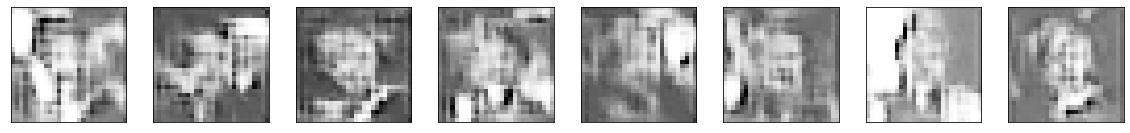

[Step 4000] D Loss: 0.6045; G Loss: 1.0326


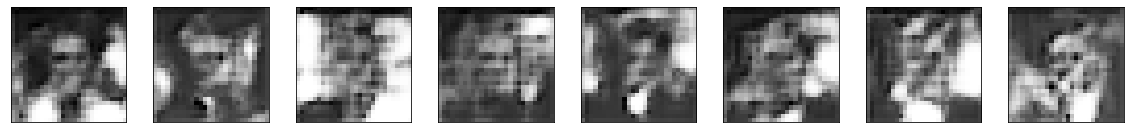

[Step 4200] D Loss: 0.3990; G Loss: 0.5117


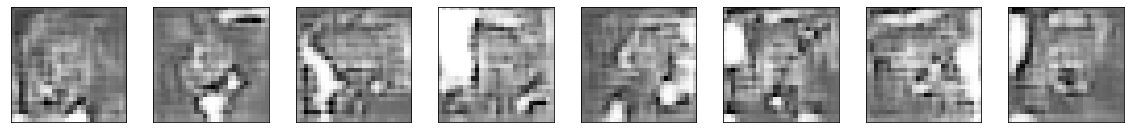

[Step 4400] D Loss: 0.3930; G Loss: 1.2856


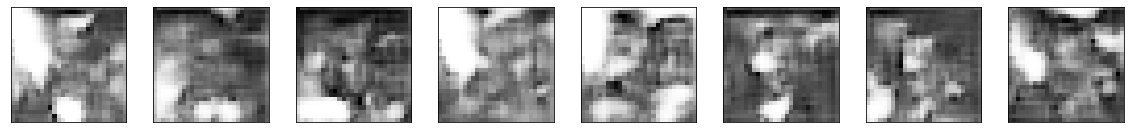

[Step 4600] D Loss: 0.4097; G Loss: 0.9951


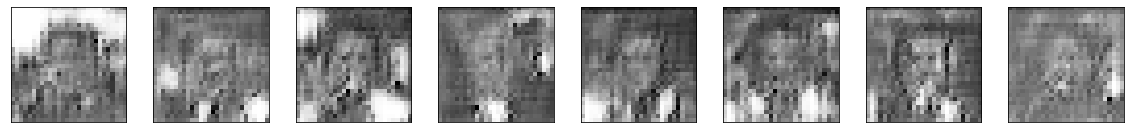

[Step 4800] D Loss: 0.2800; G Loss: 2.4507


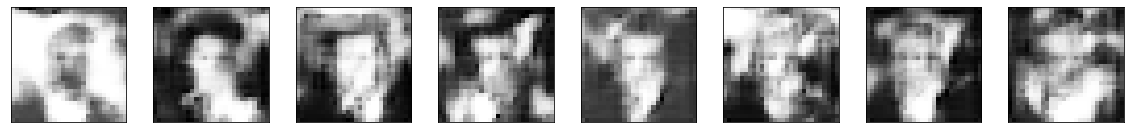

[Step 5000] D Loss: 0.6890; G Loss: 0.4000


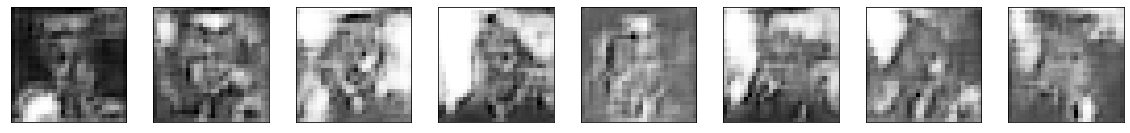

[Step 5200] D Loss: 0.6548; G Loss: 0.8922


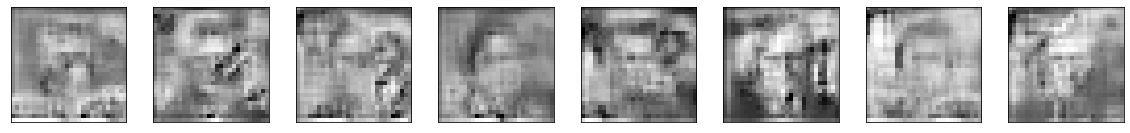

[Step 5400] D Loss: 0.5326; G Loss: 0.8153


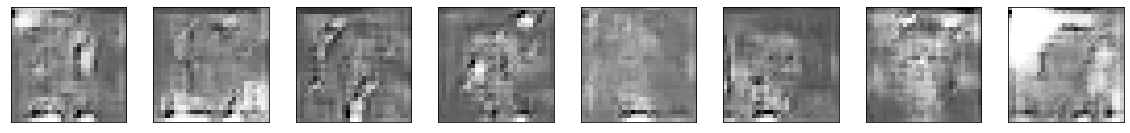

[Step 5600] D Loss: 0.5557; G Loss: 0.6624


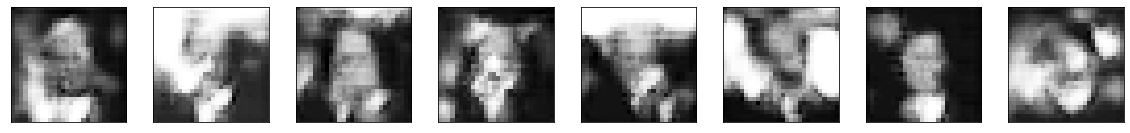

[Step 5800] D Loss: 0.5640; G Loss: 1.4315


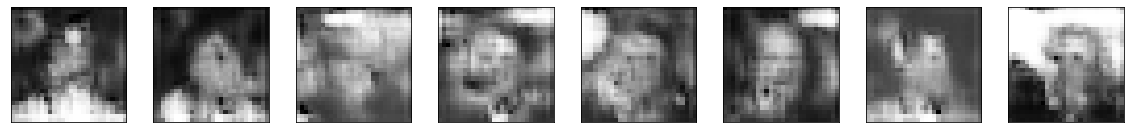

[Step 6000] D Loss: 0.7935; G Loss: 1.0743


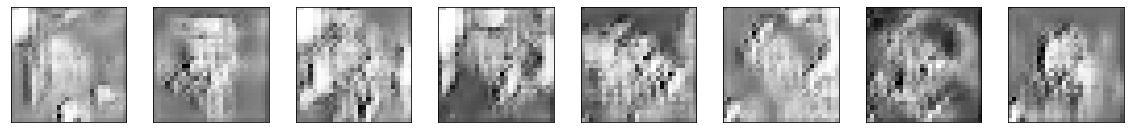

[Step 6200] D Loss: 0.5260; G Loss: 1.0793


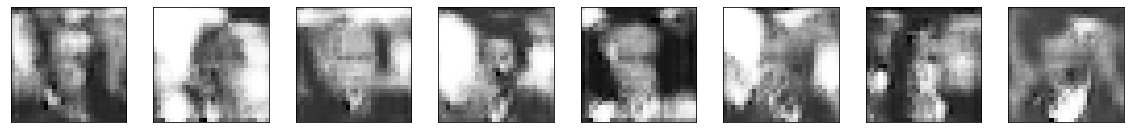

[Step 6400] D Loss: 0.5656; G Loss: 0.7323


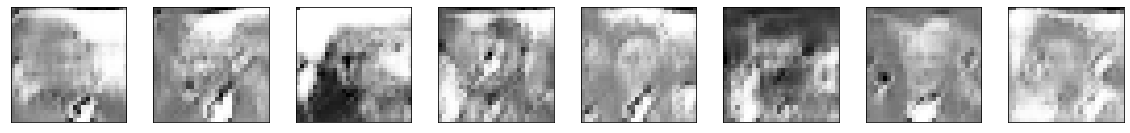

[Step 6600] D Loss: 0.5581; G Loss: 2.0411


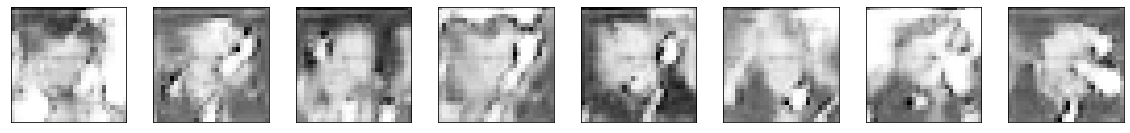

[Step 6800] D Loss: 0.8132; G Loss: 0.6272


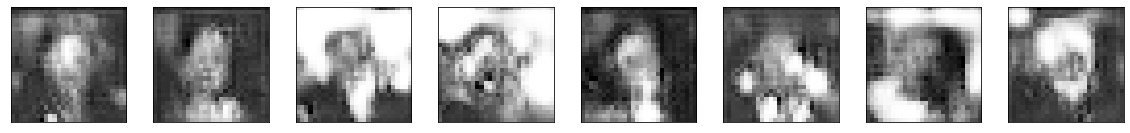

[Step 7000] D Loss: 0.5299; G Loss: 0.8109


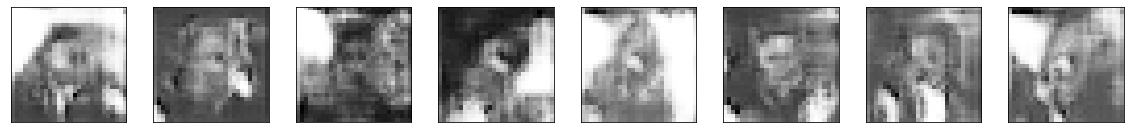

[Step 7200] D Loss: 0.1848; G Loss: 1.6926


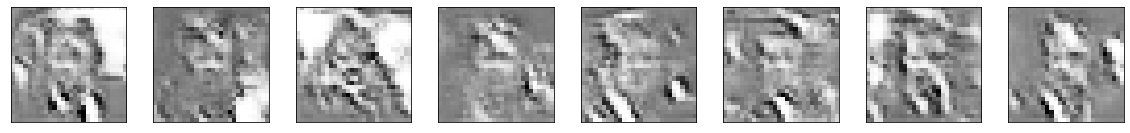

[Step 7400] D Loss: 0.5985; G Loss: 0.6807


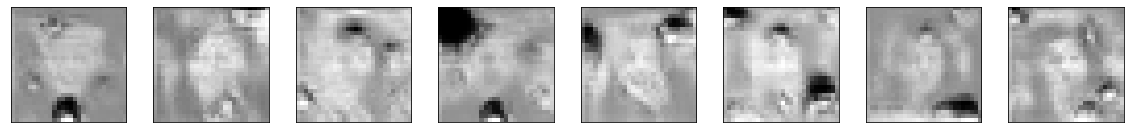

[Step 7600] D Loss: 0.5607; G Loss: 0.9270


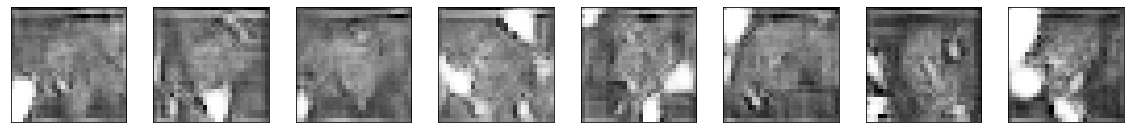

[Step 7800] D Loss: 0.5930; G Loss: 1.1726


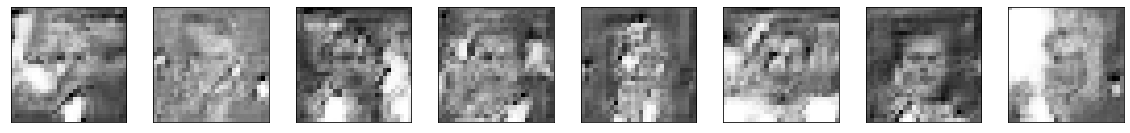

[Step 8000] D Loss: 0.8392; G Loss: 0.6311


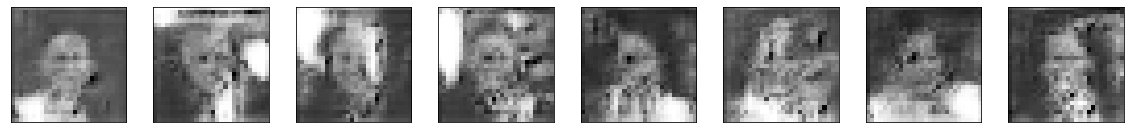

[Step 8200] D Loss: 0.3960; G Loss: 1.3427


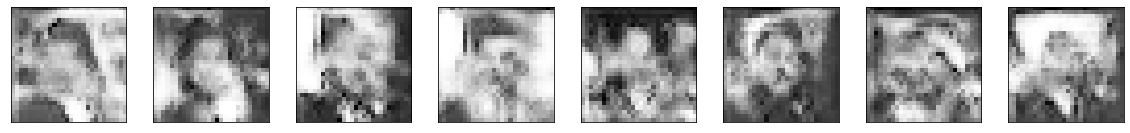

[Step 8400] D Loss: 0.4589; G Loss: 1.2407


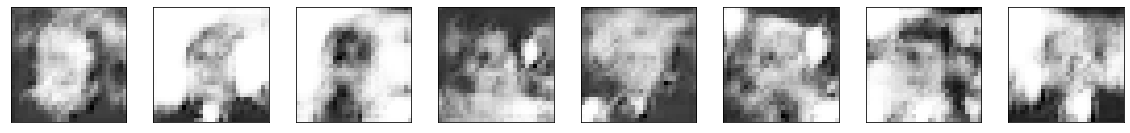

[Step 8600] D Loss: 0.5879; G Loss: 1.5548


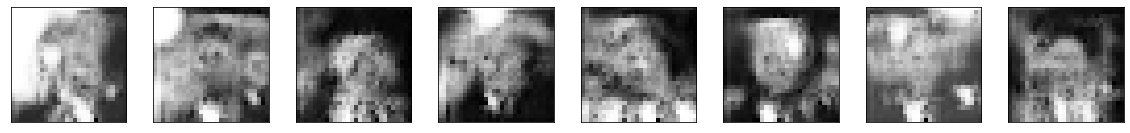

[Step 8800] D Loss: 0.3320; G Loss: 1.3822


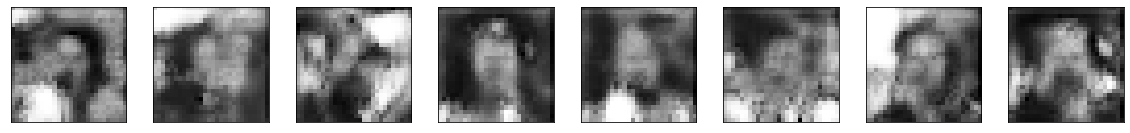

[Step 9000] D Loss: 0.4134; G Loss: 1.4496


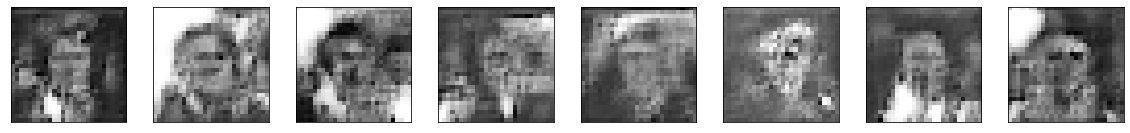

[Step 9200] D Loss: 0.6210; G Loss: 1.1380


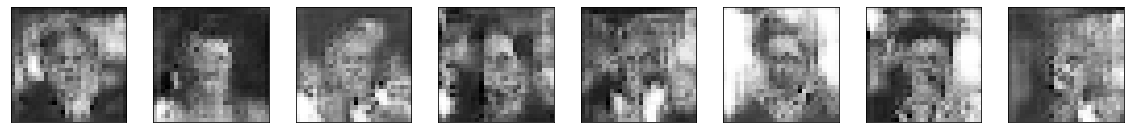

[Step 9400] D Loss: 0.3929; G Loss: 1.3425


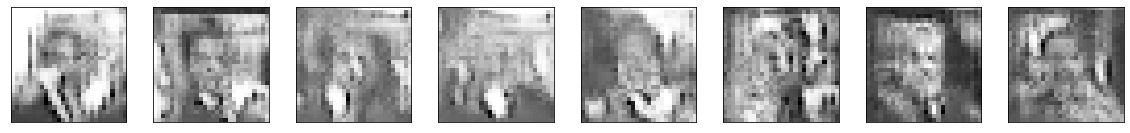

[Step 9600] D Loss: 0.6074; G Loss: 0.9377


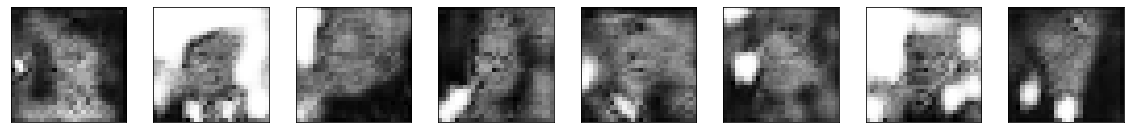

[Step 9800] D Loss: 0.6011; G Loss: 1.4624


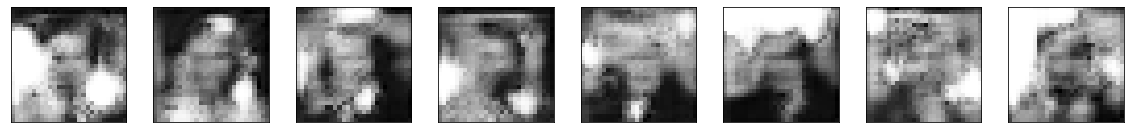

[Step 10000] D Loss: 0.5148; G Loss: 1.0159


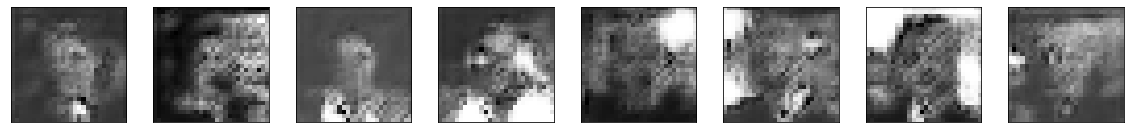

[Step 10200] D Loss: 0.9402; G Loss: 1.6332


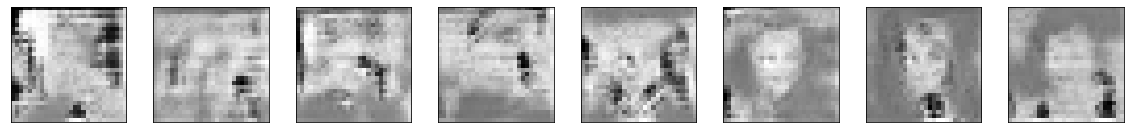

[Step 10400] D Loss: 0.4083; G Loss: 1.4424


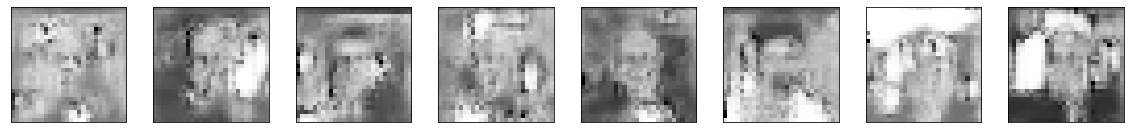

[Step 10600] D Loss: 0.4360; G Loss: 1.7048


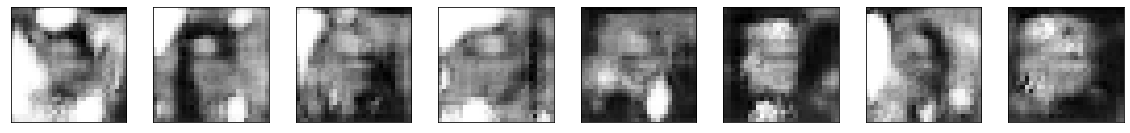

[Step 10800] D Loss: 0.5292; G Loss: 1.9283


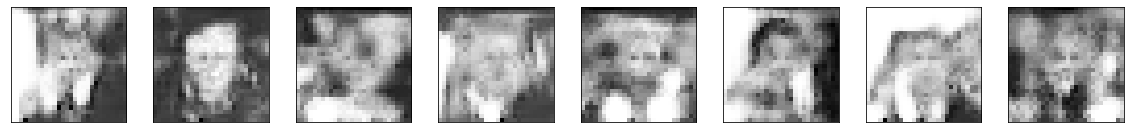

[Step 11000] D Loss: 0.8152; G Loss: 0.8104


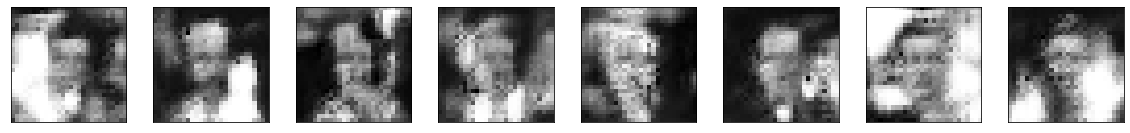

[Step 11200] D Loss: 0.4198; G Loss: 1.1352


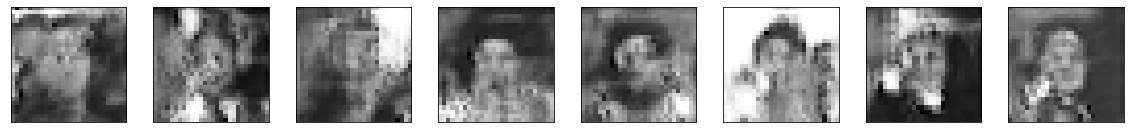

[Step 11400] D Loss: 0.5460; G Loss: 1.1211


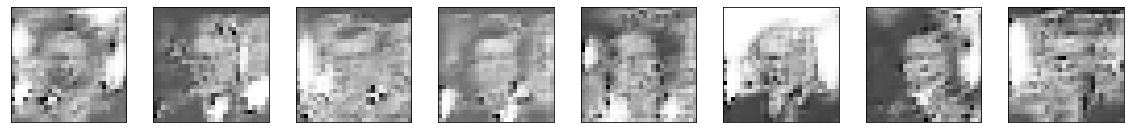

[Step 11600] D Loss: 0.3862; G Loss: 1.6964


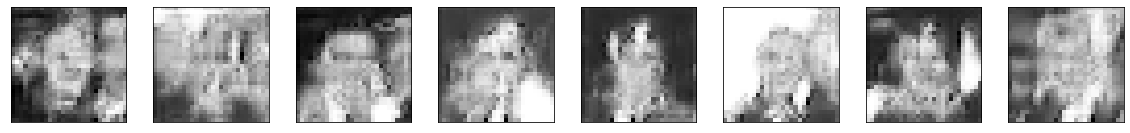

[Step 11800] D Loss: 0.5154; G Loss: 0.5833


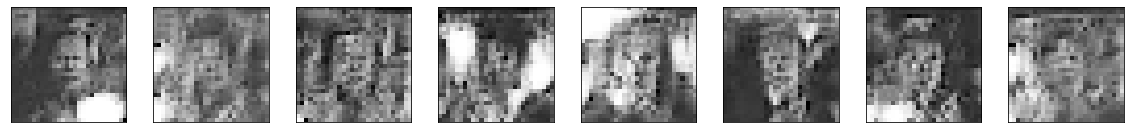

[Step 12000] D Loss: 0.5738; G Loss: 1.1931


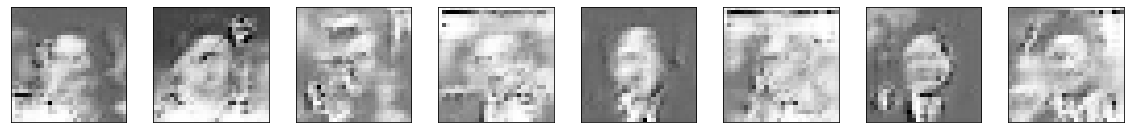

[Step 12200] D Loss: 0.5949; G Loss: 1.2696


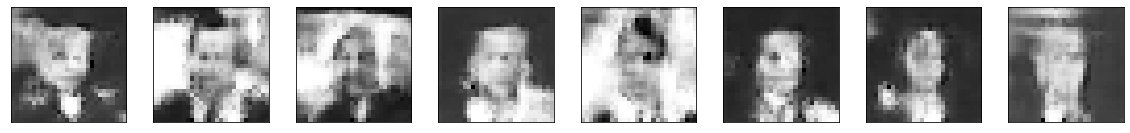

[Step 12400] D Loss: 0.3518; G Loss: 1.5624


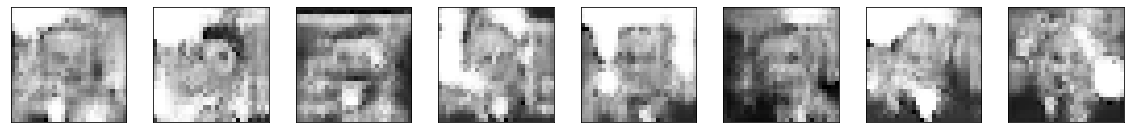

[Step 12600] D Loss: 0.2204; G Loss: 1.3932


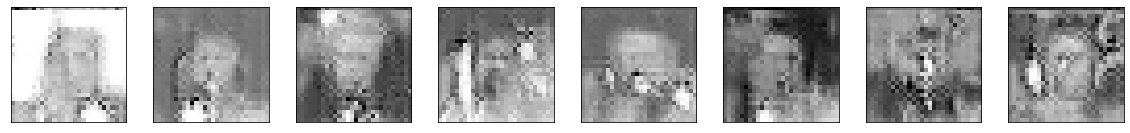

[Step 12800] D Loss: 0.4699; G Loss: 0.8072


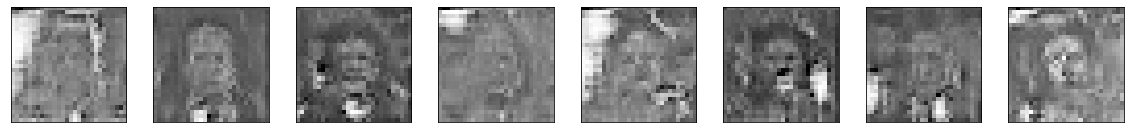

[Step 13000] D Loss: 0.4302; G Loss: 1.0352


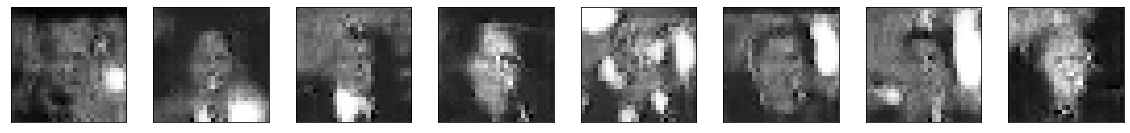

[Step 13200] D Loss: 0.5086; G Loss: 1.8146


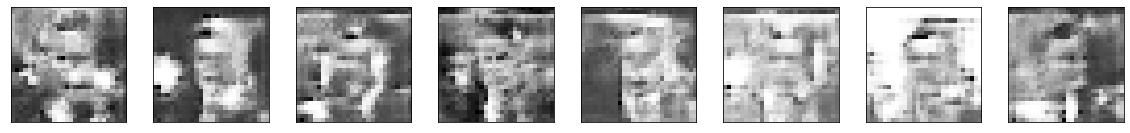

[Step 13400] D Loss: 0.5962; G Loss: 2.1164


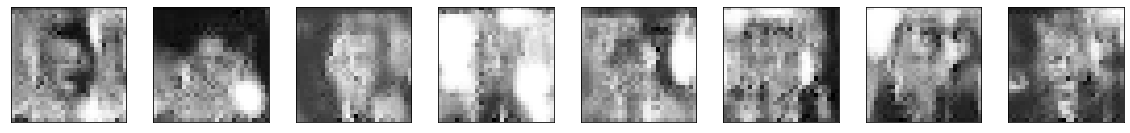

[Step 13600] D Loss: 0.5641; G Loss: 1.6511


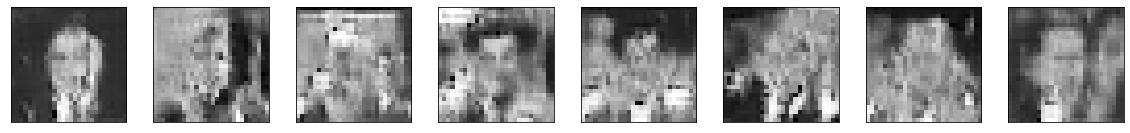

[Step 13800] D Loss: 0.4664; G Loss: 2.0251


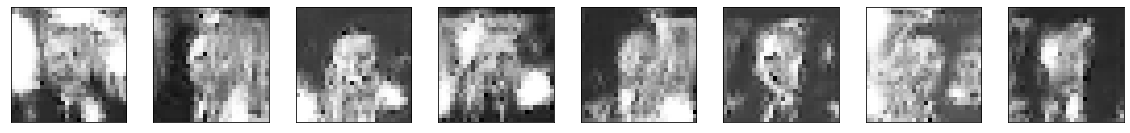

[Step 14000] D Loss: 0.3974; G Loss: 1.6323


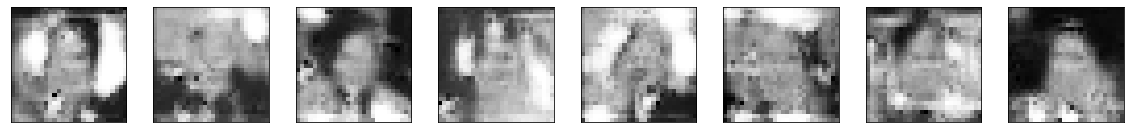

[Step 14200] D Loss: 0.4432; G Loss: 1.2995


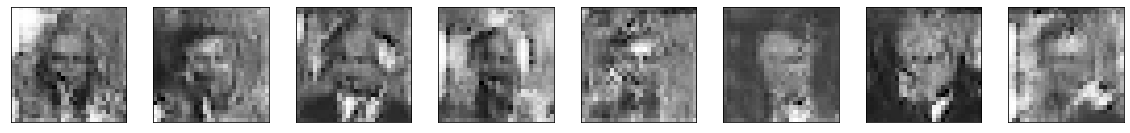

[Step 14400] D Loss: 0.5217; G Loss: 1.7066


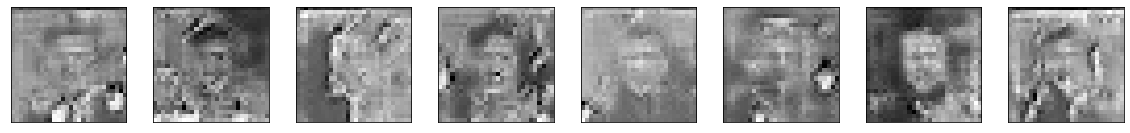

[Step 14600] D Loss: 0.5370; G Loss: 1.9005


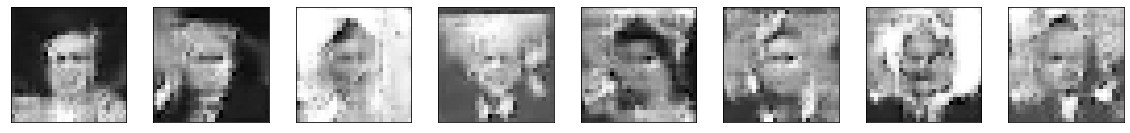

[Step 14800] D Loss: 0.5345; G Loss: 1.0410


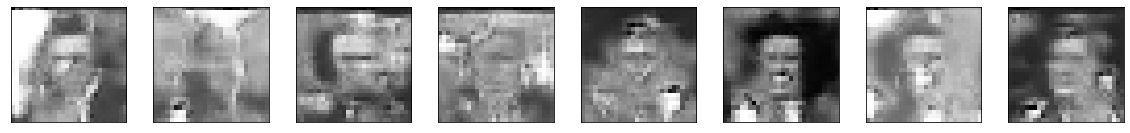

[Step 15000] D Loss: 0.4874; G Loss: 2.3434


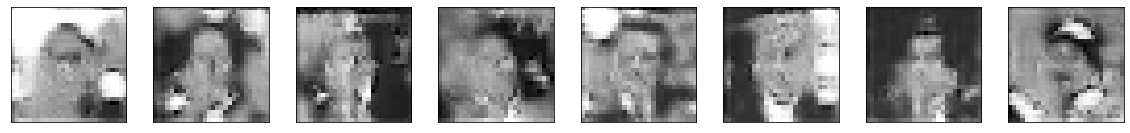

[Step 15200] D Loss: 0.6666; G Loss: 1.5002


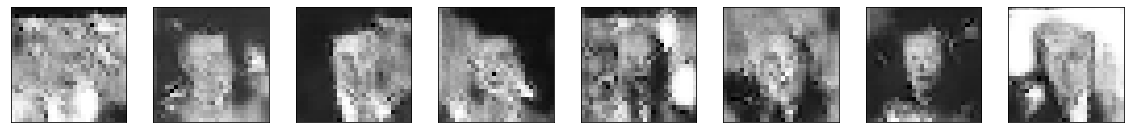

[Step 15400] D Loss: 0.5482; G Loss: 2.2966


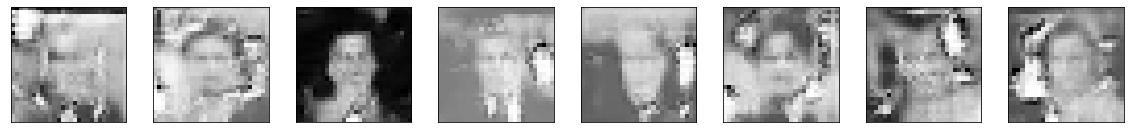

[Step 15600] D Loss: 0.3165; G Loss: 2.1650


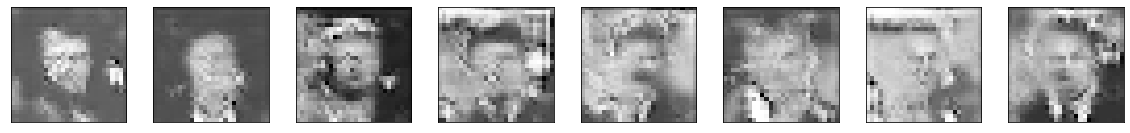

[Step 15800] D Loss: 0.5484; G Loss: 1.0770


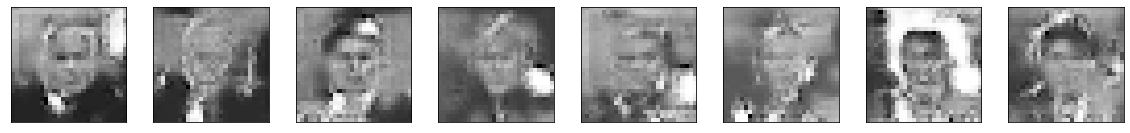

[Step 16000] D Loss: 0.7409; G Loss: 0.9951


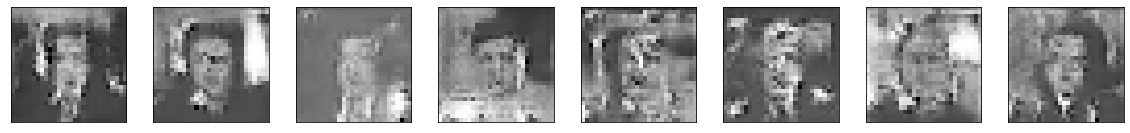

[Step 16200] D Loss: 0.6525; G Loss: 1.3060


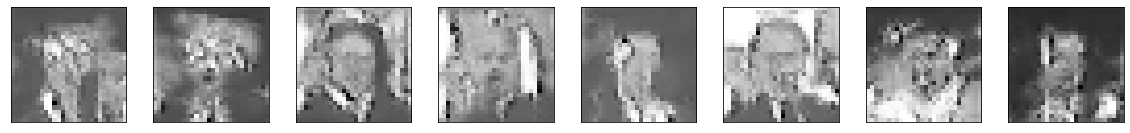

[Step 16400] D Loss: 0.5381; G Loss: 0.8720


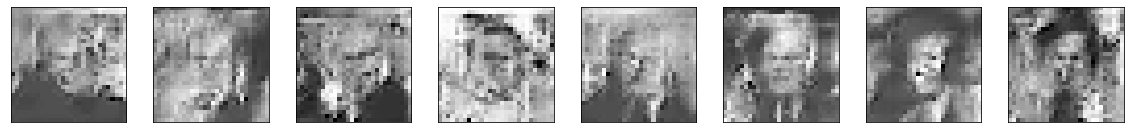

In [14]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_pics(syntetic_images)


## Тестирование свёрточного генератора

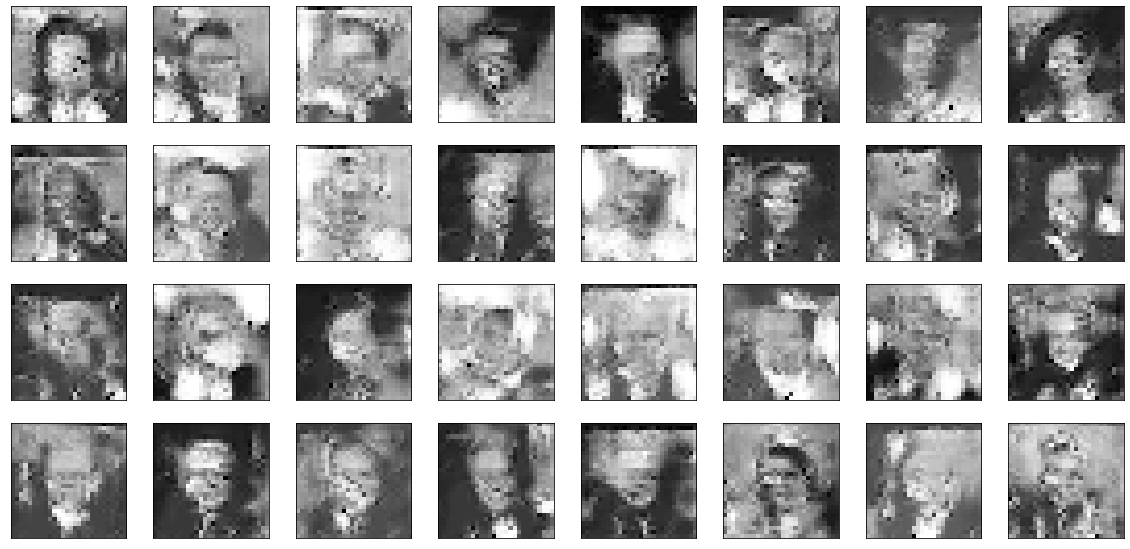

In [15]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)

## Интерполяция в латентном пространстве

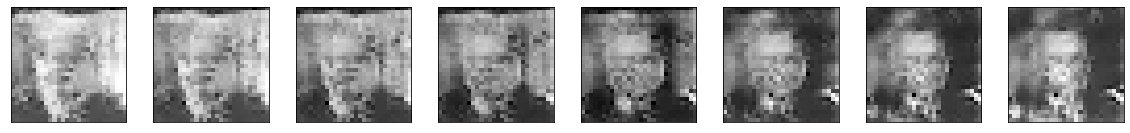

In [16]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_pics(syntetic_images)